In [5]:
!pip install git+https://github.com/BindsNET/bindsnet.git

  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-qos24ee3
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-qos24ee3
  Resolved https://github.com/BindsNET/bindsnet.git to commit 666dd447c0442a9cddfc6165f79f94fc522446db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 6.5 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 9.4 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
class LatencyEncoder:
    def __init__(self, time: int = 100):
        self.time = time  # Общее число временных шагов

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        image: Tensor [1, 28, 28] или [28, 28], значения от 0 до 1 или до 255
        return: spike_tensor [time, 1, 784]
        """
        if image.ndim == 3:
            image = image.squeeze()

        if image.max() > 1:
            image = image / 255.0

        spike_tensor = torch.zeros((self.time, 1, 784))

        for i in range(28):
            for j in range(28):
                pixel = image[i, j].item()
                if pixel > 0:
                    spike_time = int((1.0 - pixel) * (self.time - 1))
                    spike_tensor[spike_time, 0, i * 28 + j] = 1.0

        return spike_tensor.view(self.time, 1, 28, 28)


# 🧠 Spiking Neural Network (SNN) на базе BindsNET с обучением через STDP

В этом эксперименте реализована простая биологически правдоподобная спайковая нейросеть (SNN) для обработки изображений MNIST.

## 📌 Архитектура сети:
- **Входной слой (`Input`, 784 нейрона)** — по одному нейрону на каждый пиксель изображения 28×28.
- **Poisson-кодировщик** — преобразует яркость пикселей в вероятностные временные спайки.
- **Полносвязный слой (`Connection`)** — соединяет вход с выходом (матрица весов 784 × 100).
- **Выходной слой (`LIF`, 100 нейронов)** — Leaky Integrate-and-Fire нейроны с утечкой и порогом.
- **STDP (Spike-Timing Dependent Plasticity)** — обучение без градиентов; веса усиливаются, если вход активен до выходного спайка.

## 🔬 Что делается:
1. Загружается одно изображение MNIST.
2. Кодируется в Poisson-спайковый поток.
3. Пропускается через сеть:
   - `Input` получает входные спайки,
   - `LIF` нейроны активируются в зависимости от весов.
4. Сохраняются:
   - Спайковая активность `LIF`-нейронов до и после подачи входа.
   - Сумма спайков на входе (`Input`) — показывает, какие пиксели активны.
   - Веса одного выбранного `LIF`-нейрона — до и после STDP.

## 📈 Визуализация:
- График: сравнение спайковой активности нейронов до/после + входные спайки.
- График: изменение весов, ведущих к нейрону `LIF[42]` — видно, как STDP усиливает значимые связи.

## 🎯 Цель:
Показать, как SNN:
- преобразует изображение в поток спайков,
- активирует только специфичные нейроны,
- адаптирует веса на основе временных шаблонов (STDP), без использования обратного распространения ошибки.


[0] Спайков в LIF: 12


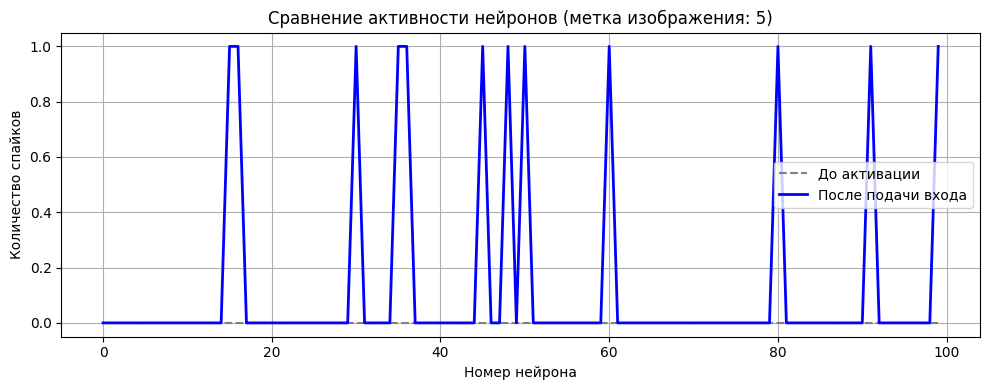

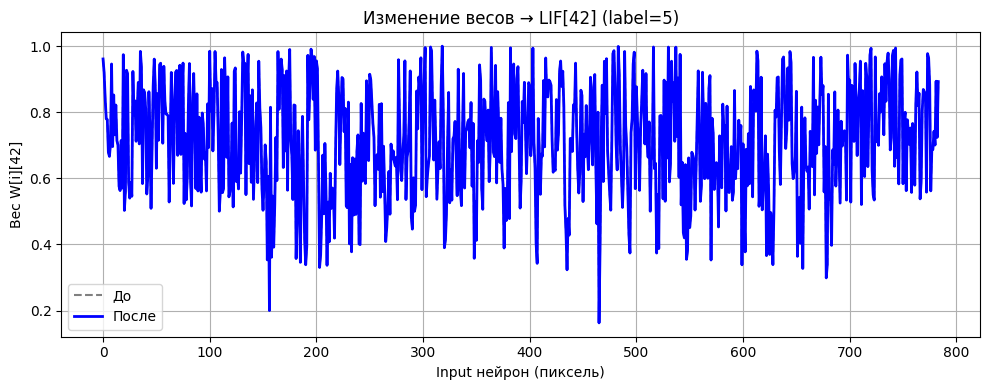

[1] Спайков в LIF: 0


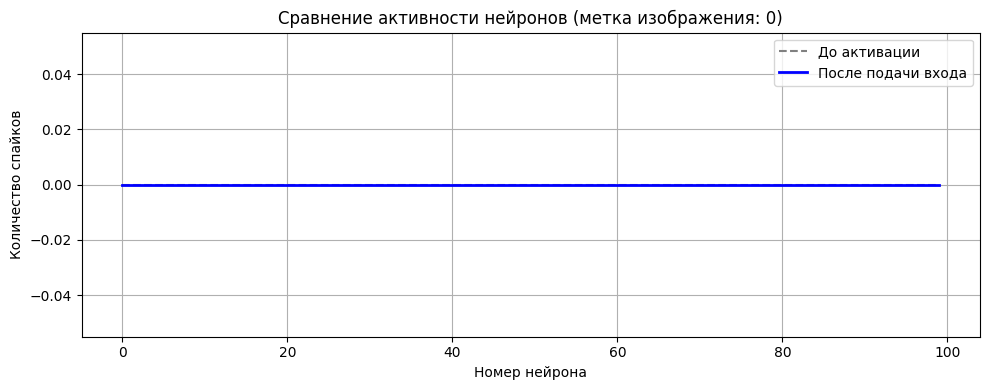

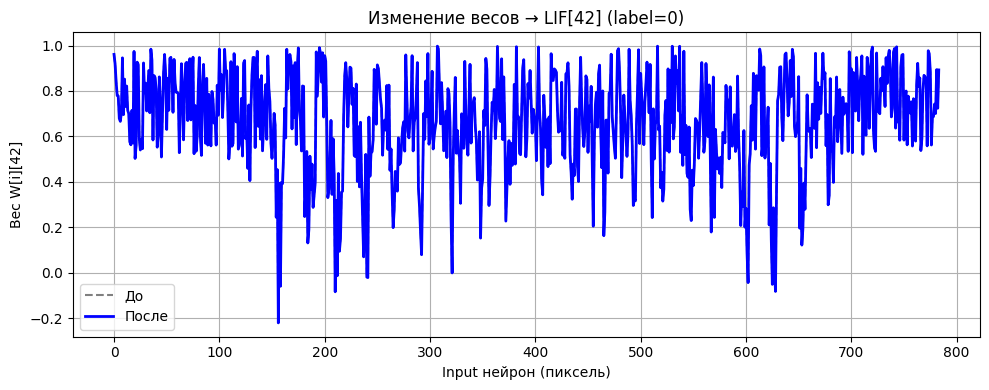

[2] Спайков в LIF: 0


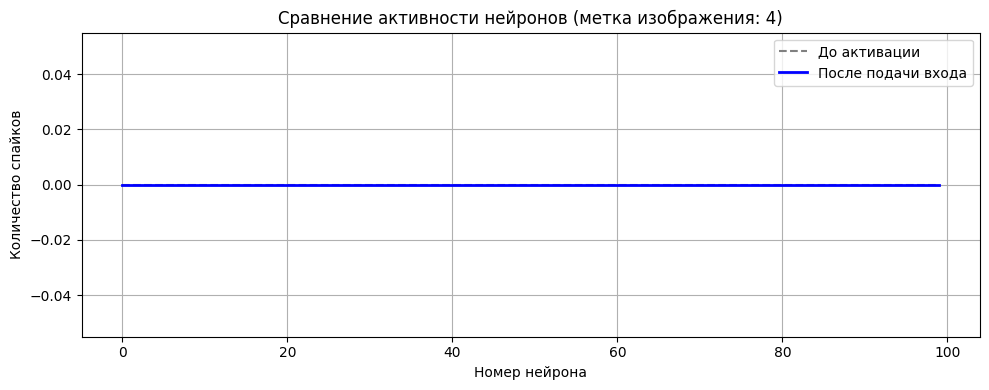

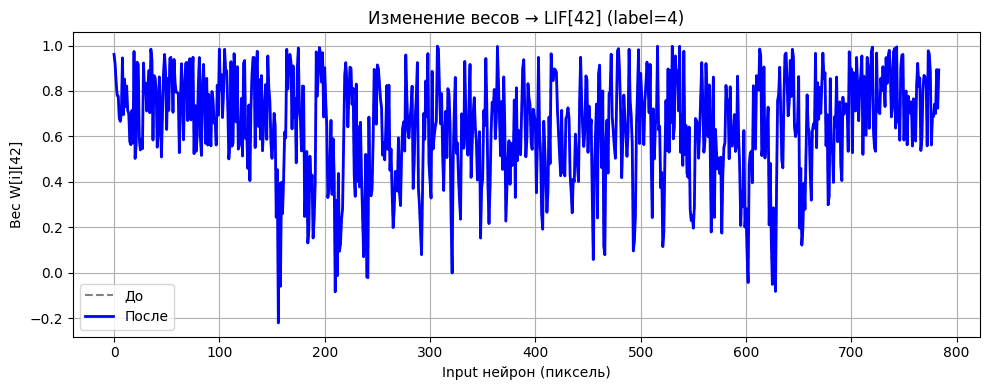

[3] Спайков в LIF: 0


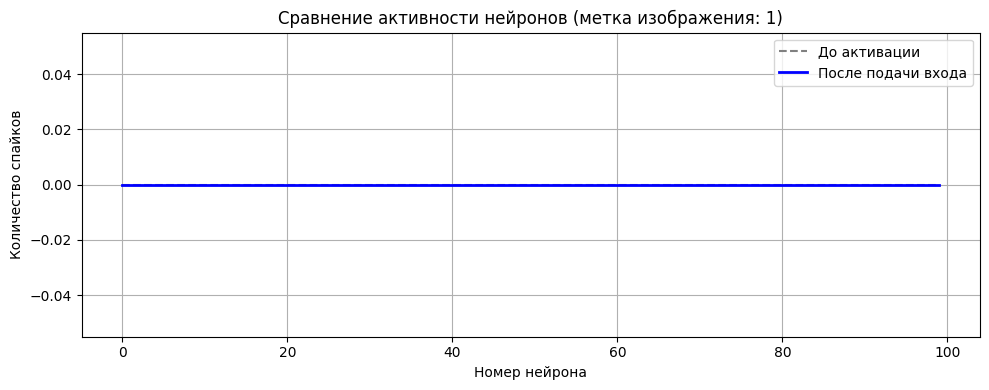

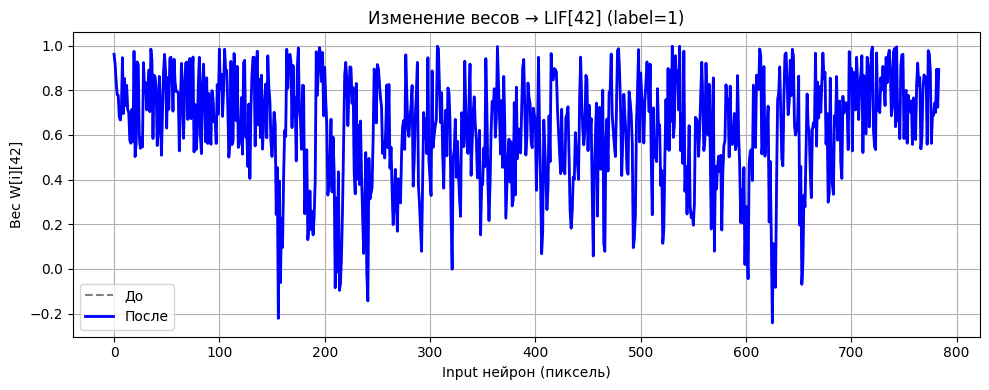

[4] Спайков в LIF: 0


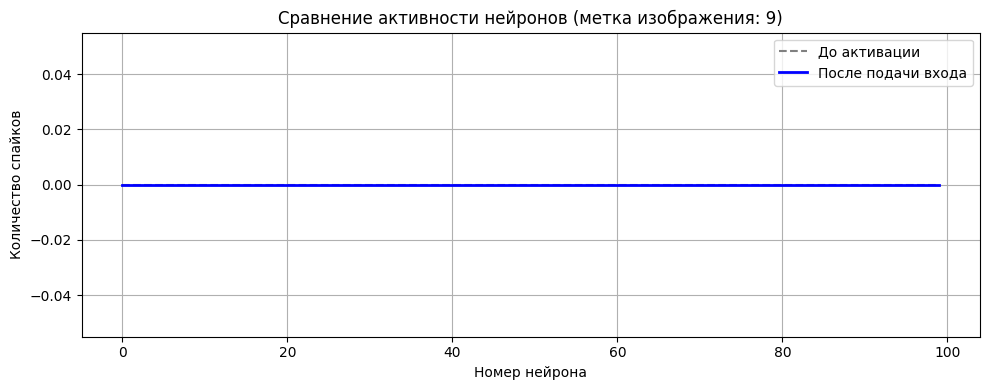

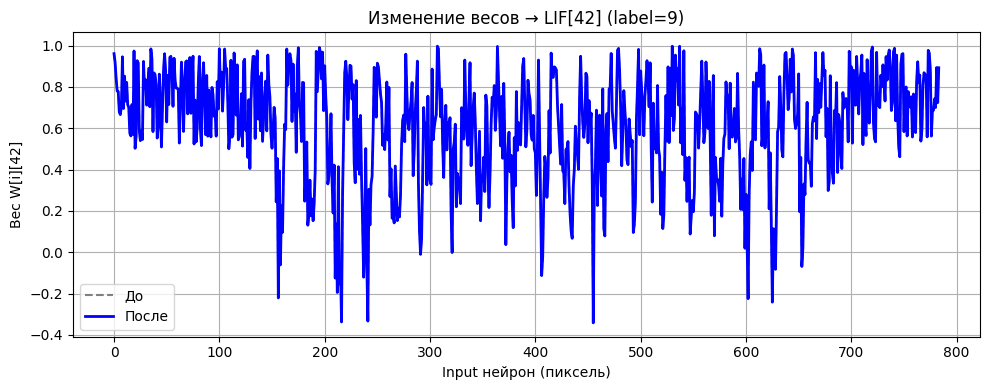

[5] Спайков в LIF: 0


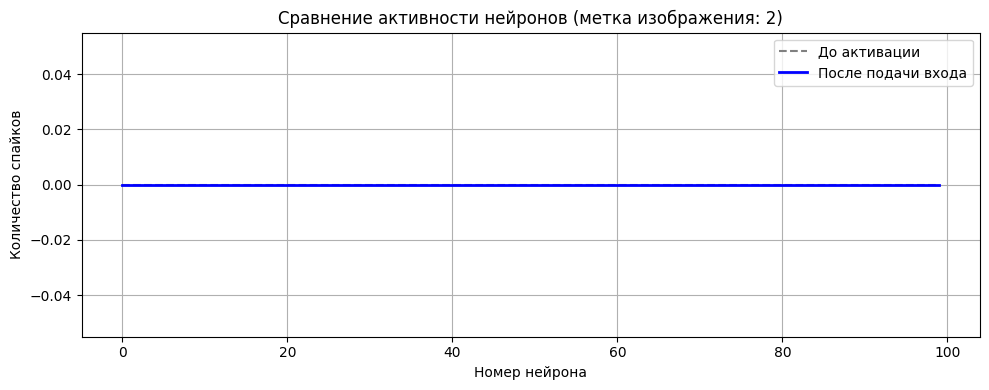

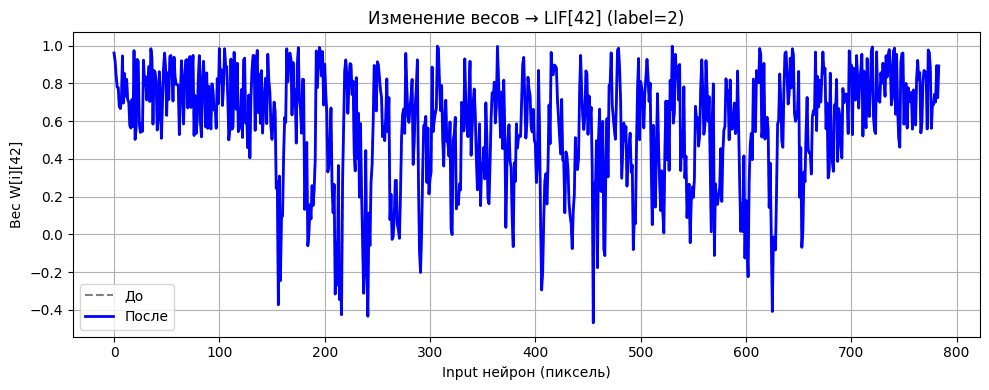

[6] Спайков в LIF: 0


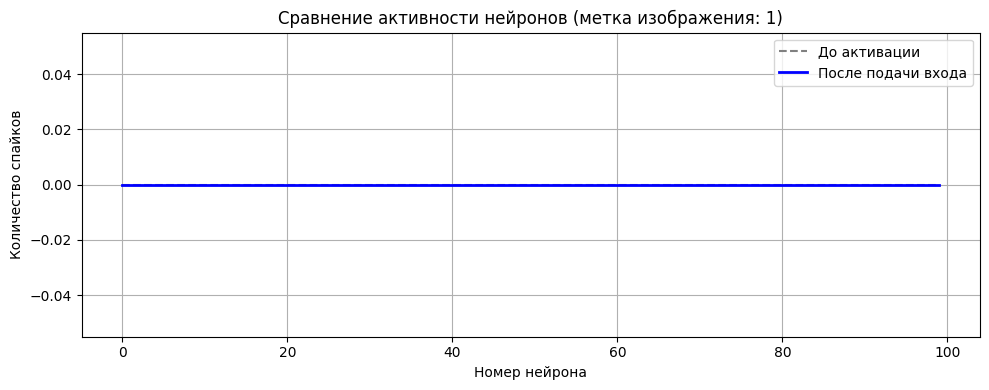

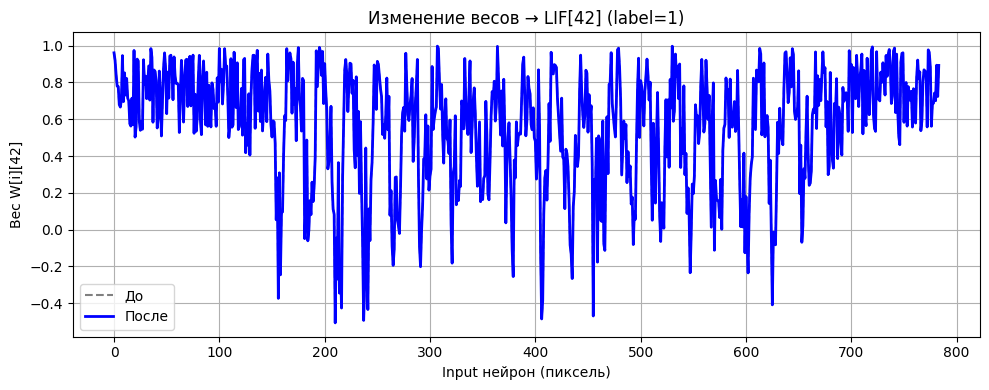

[7] Спайков в LIF: 0


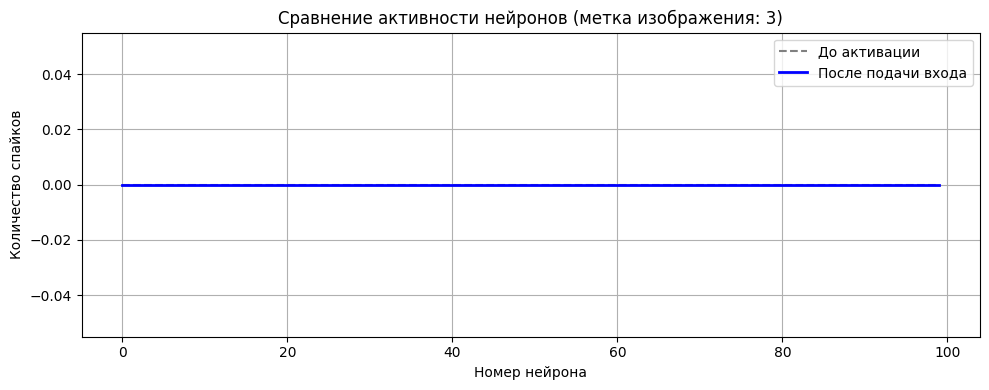

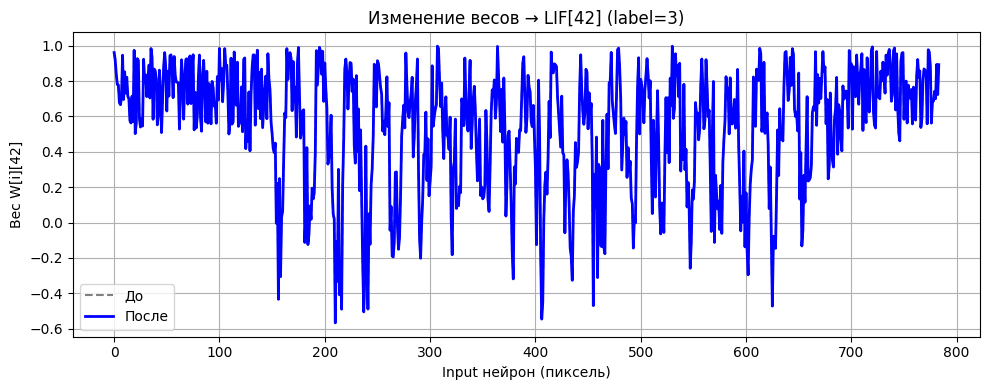

[8] Спайков в LIF: 0


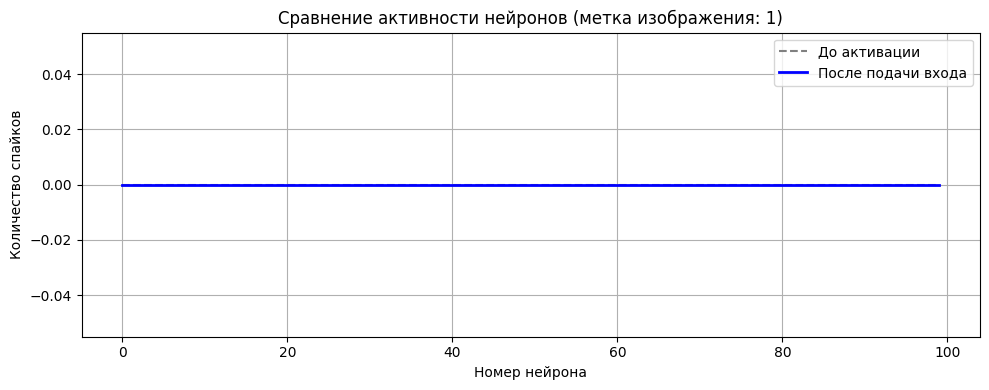

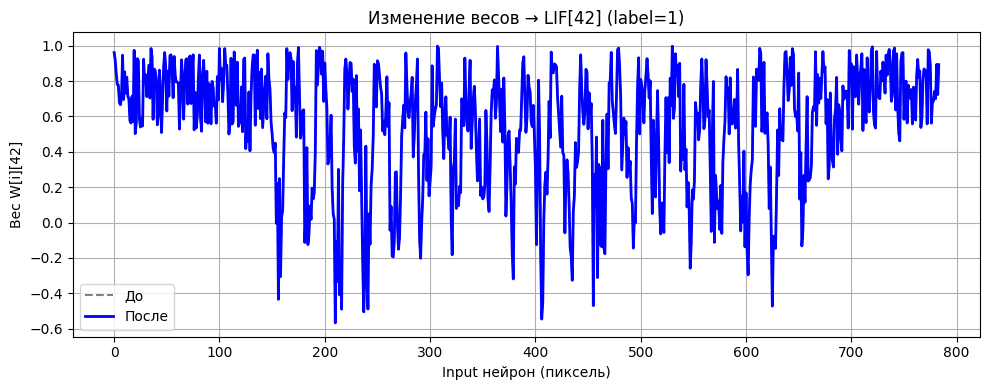

[9] Спайков в LIF: 0


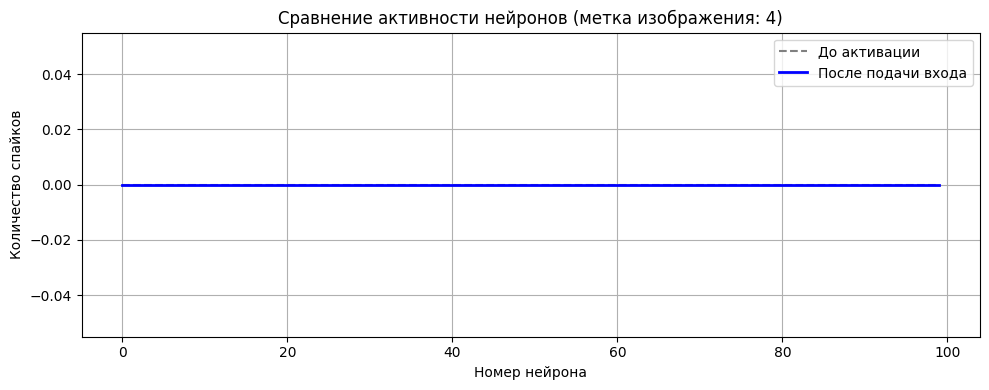

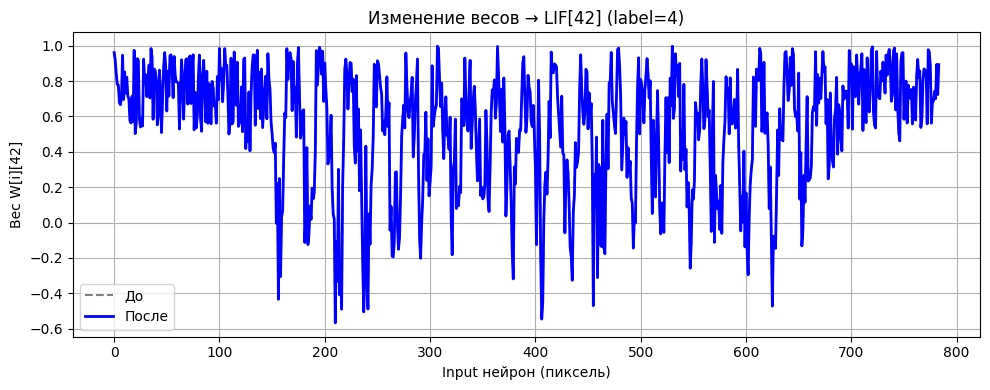

In [14]:

# ⚠️ Установка BindsNET
#!pip install bindsnet

# 📦 Импорты
import torch
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, IzhikevichNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre
from bindsnet.analysis.plotting import plot_spikes, plot_weights
from bindsnet.pipeline import EnvironmentPipeline
from bindsnet.encoding import PoissonEncoder
from bindsnet.network.nodes import Input, LIFNodes
from torchvision import transforms
from bindsnet.datasets import MNIST
import matplotlib.pyplot as plt



# 📚 Загрузка датасета MNIST
transform = transforms.Compose([transforms.ToTensor()])
dataset = MNIST(root='./data', train=True, download=True, transform=transform)
# 🎯 Параметры
time = 200  # временное окно
n_hidden = 100
batch_size = 1

# 🧠 Инициализация сети
net = Network()

# Входной слой
input_layer = Input(n=784, shape=(1, 28, 28), traces=True)
net.add_layer(input_layer, name='Input')

# Скрытый слой на нейронах Ижикевича
lif_layer = LIFNodes(n=n_hidden, traces=True, thresh=-52.0)
net.add_layer(lif_layer, name='LIF')

# Связи и STDP
connection = Connection(source=input_layer, target=lif_layer)
connection.update_rule = PostPre(connection=connection, nu=(0.2, -0.2))
net.add_connection(connection, source='Input', target='LIF')


# Усилим веса
connection.w.data.uniform_(0.5, 1.0)

# Poisson-кодировщик
encoder = LatencyEncoder(time=time)

# 🚀 Обучение и визуализация
for i in range(10):
    sample = dataset[i]
    image = sample["image"]
    image = image / image.max()
    label = sample["label"]  # Метка класса
    image_np = image.squeeze().numpy()
    spike_input = encoder(image_np)  # [time, 1, 784]    # [time, 1, 28, 28]
    #spike_input = spike_input.view(time, 1, 784)

    inputs = {"Input": spike_input}
    spikes_before = lif_layer.s.clone().sum(0).squeeze().cpu().numpy()
    spikes_input_sum = spike_input.sum(0).squeeze().cpu().numpy()  # [784]
    # ДО запуска
    weights_before = connection.w[:, 42].detach().cpu().numpy()
    net.run(inputs=inputs, time=time)
    spikes_after = lif_layer.s.sum(0).squeeze().cpu().numpy()
    print(f"[{i}] Спайков в LIF:", lif_layer.s.sum().item())
    # ПОСЛЕ запуска
    weights_after = connection.w[:, 42].detach().cpu().numpy()
    # Визуализация
    plt.figure(figsize=(10, 4))
    plt.plot(spikes_before, label="До активации", linestyle="--", color="gray")
    plt.plot(spikes_after, label="После подачи входа", linewidth=2, color="blue")
    #plt.plot(spikes_input_sum[:n_hidden], label="Входные спайки (пиксели)", linewidth=1.5, color="orange")

    plt.xlabel("Номер нейрона")
    plt.ylabel("Количество спайков")
    plt.title(f"Сравнение активности нейронов (метка изображения: {label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Визуализация изменения весов
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(weights_before, label="До", linestyle="--", color="gray")
    plt.plot(weights_after, label="После", linewidth=2, color="blue")
    plt.xlabel("Input нейрон (пиксель)")
    plt.ylabel("Вес W[i][42]")
    plt.title(f"Изменение весов → LIF[42] (label={label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    net.reset_state_variables()


In [38]:
net.layers["LIF"].s 

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])

In [39]:
spike_tensor = net.layers["LIF"].s     # [T, 1, N]
spike_counts = spike_tensor.sum(dim=0) # → [1, N]
spike_vector = spike_counts.squeeze()  # → [N]

In [40]:
print(spike_vector)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


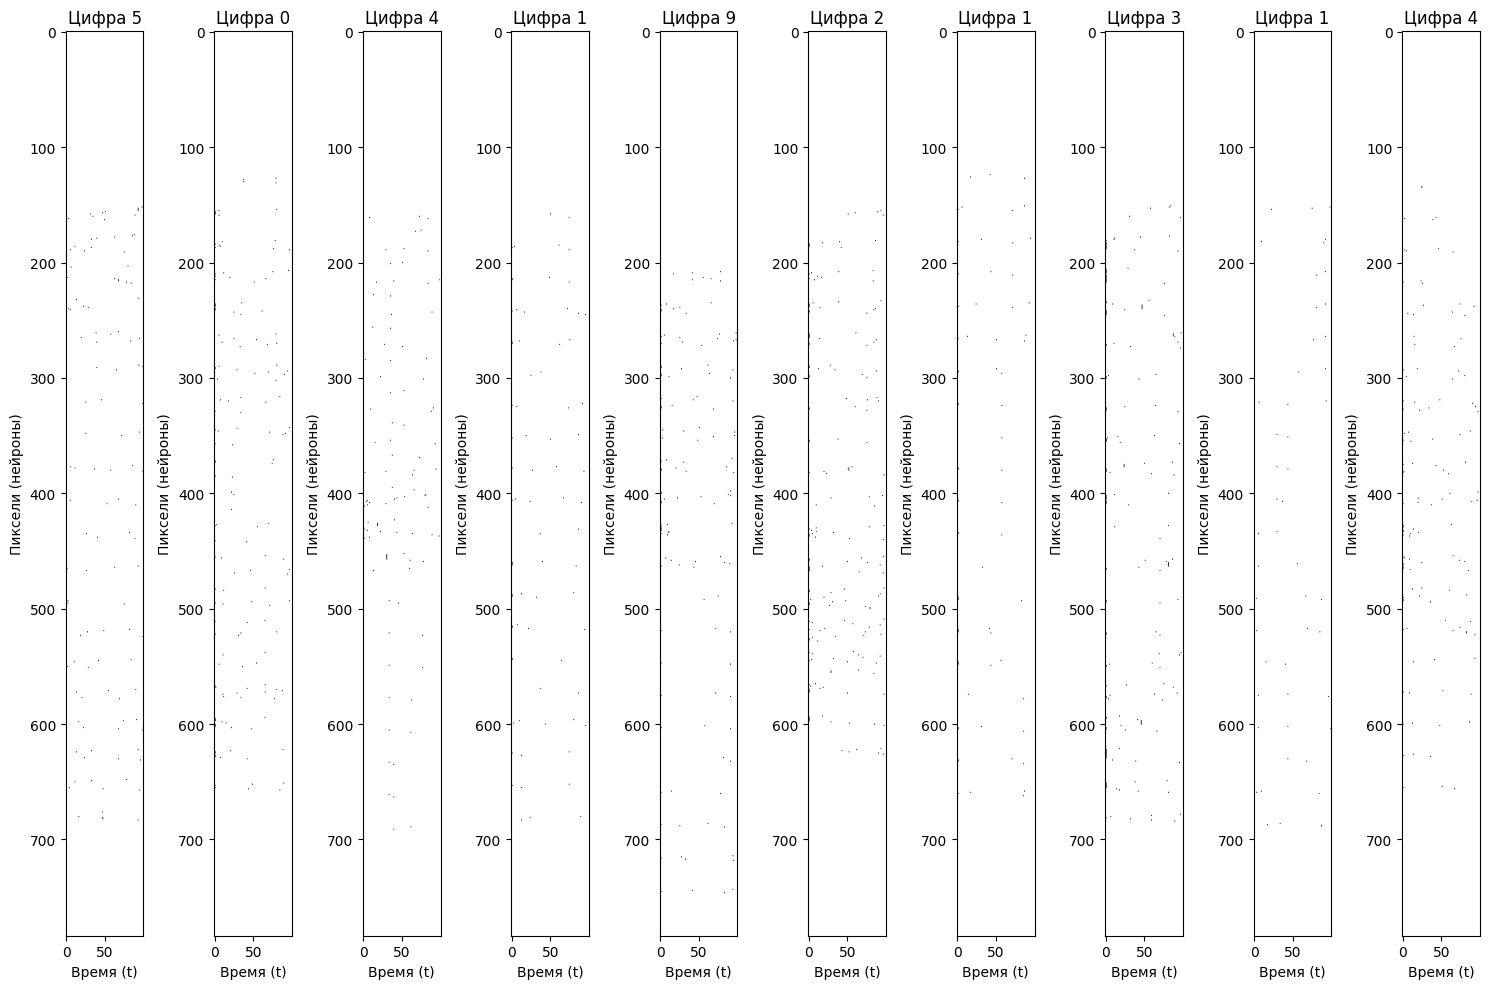

In [10]:
def plot_latency(spike_tensor, label):
    t_flat = spike_tensor.view(spike_tensor.shape[0], -1)  # [T, 784]
    plt.imshow(t_flat.T, cmap="gray_r", aspect="auto")
    plt.title(f"Цифра {label}")
    plt.xlabel("Время (t)")
    plt.ylabel("Пиксели (нейроны)")

# === Использование ===
dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
encoder = LatencyEncoder(time=100)

plt.figure(figsize=(15, 10))
for idx, i in enumerate([0, 1, 2, 3, 4,5,6,7,8,9]):
    sample = dataset[i]
    spike_tensor = encoder(sample["image"])
    plt.subplot(1, 10, idx + 1)
    plot_latency(spike_tensor, sample["label"])

plt.tight_layout()
plt.show()